In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
def plot_processes(data):
    data = data.copy()
    SSD = data['SSD'].values[0]
    unpacked_go_process = pd.DataFrame(data["go_process"].values.tolist())
    unpacked_stop_process = pd.DataFrame(data["stop_process"].values.tolist())

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    mean_go = unpacked_go_process.mean()
    std_go = unpacked_go_process.std()
    go_time = np.arange(params['nondecisiongo'], params['maxtime']+1)
    axes[0].plot(go_time, mean_go)
    axes[0].fill_between(go_time, mean_go+std_go, mean_go-std_go, alpha = 0.4)
    _ = axes[0].set_title('mean go process')
    _ = axes[0].set_ylabel('SSD = {}'.format(SSD))

    mean_stop = unpacked_stop_process.mean()
    std_stop = unpacked_stop_process.std()
    stop_time = np.arange(SSD + params['nondecisionstop'], params['maxtime']+1)
    axes[1].plot(stop_time, mean_stop)
    axes[1].fill_between(stop_time, mean_stop+std_stop, mean_stop-std_stop, alpha = 0.4)
    _ = axes[1].set_title('mean stop process')
    plt.show()
    plt.close()
    


In [9]:
params={'mugo':.2,
        'mu_stop':.8,
        'noiseScale': 1,
        'threshold':60,
        'nondecisiongo':50,
        'nondecisionstop':50,
        'inhibitionParam':1, 
        'ssds':[1,50,100,150, 200,250, 300, 350, 400, 450, 500, 750],
        'nreps':1000,
        'maxtime':100000,
        'pTriggerFail': .15
       }

# "Boucher et al., 2007 Interactive Race Model"

In [4]:
def interactive_race(params):
    data_dict = {
        'SSD': [],
        'rep': [],
        'go_process': [],
        'stop_process': [],
        'go_accum': [],
        'stop_accum': [],
        'RT': [],
    }
    for SSD in params['ssds']:
        stop_init_time = SSD + params['nondecisionstop']
        for rep in range(params['nreps']):
            go_process = []
            stop_process = []
            go_accum = 0
            stop_accum = 0
            RT = None
            time = 0
            while time < params['maxtime'] and RT is None: # single trial
                time = time + 1
                if time >= stop_init_time:
                    stop_accum = at_least_0(
                        stop_accum + params['mu_stop'] + np.random.normal(loc=0, scale=params['noiseScale'])
                    )
                    stop_process.append(stop_accum)
                if time >= params['nondecisiongo']:
                    go_accum = at_least_0(
                        go_accum + params['mugo'] - \
                        params['inhibitionParam']*stop_accum + \
                        np.random.normal(loc=0, scale=params['noiseScale'])
                    )
                    go_process.append(go_accum)
                if go_accum > params['threshold']:
                    RT = time

            # Save data
            data_dict['SSD'].append(SSD)
            data_dict['rep'].append(rep)
            data_dict['RT'].append(RT)
            data_dict['go_process'].append(go_process)
            data_dict['stop_process'].append(stop_process)
            data_dict['go_accum'].append(go_accum)
            data_dict['stop_accum'].append(stop_accum)
    return pd.DataFrame(data_dict)

In [5]:
data = interactive_race(params)
data

,SSD,rep,go_process,stop_process,go_accum,stop_accum,RT
0,1,0,"[0, 0.5131308594353048, 0, 0, 0, 0, 0, 0, 0, 0...","[0.15974968030624181, 0, 2.709874064433417, 4....",0.000000,713.781402,NaN
1,1,1,"[1.9475057072545865, 2.7520818251223114, 2.790...","[0, 1.0223329195663293, 0.8796853804600108, 3....",0.000000,792.481050,NaN
2,1,2,"[0, 1.0108086635772435, 2.0717656245887444, 2....","[0, 0, 0.09115842111124772, 0, 2.5234704962750...",0.000000,783.127090,NaN
3,1,3,"[1.8306699478792006, 0.486576857008567, 0, 0, ...","[1.9622430579896268, 4.40012149481028, 6.36530...",0.000000,754.508938,NaN
4,1,4,"[1.1140032013167358, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.25693346082935686, 2.5382358281607664, 4.08...",0.000000,765.097827,NaN
...,...,...,...,...,...,...,...
11995,750,995,"[2.978263433283988, 0.3482091855288343, 0, 0, ...",[],60.552770,0.000000,354.0
11996,750,996,"[1.6693959147786517, 1.0510502430041915, 1.543...",[],60.495289,0.000000,272.0
11997,750,997,"[0.5321044396627098, 1.764519179735487, 2.0488...",[],60.138218,0.000000,335.0
11998,750,998,"[0.05366843921500786, 0.09865659650872224, 2.4...",[],60.883781,0.000000,224.0


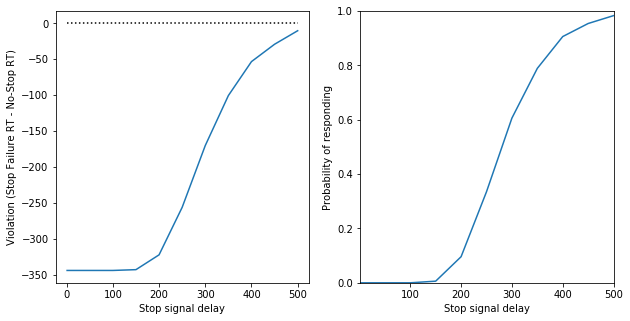

In [6]:
meanrtgo = data.fillna(0).groupby('SSD').mean()['RT'].values
presp = data.groupby('SSD').count()['RT'].values / params['nreps']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(params['ssds'][:-1],meanrtgo[:-1] - meanrtgo[-1])
plt.plot([params['ssds'][0],params['ssds'][10]],[0,0],'k:')
plt.xlabel('Stop signal delay')
plt.ylabel('Violation (Stop Failure RT - No-Stop RT)')
plt.subplot(1,2,2)
plt.plot(params['ssds'][:11],presp[:11])
plt.xlabel('Stop signal delay')
plt.ylabel('Probability of responding')
_ = plt.axis([params['ssds'][0],params['ssds'][10],0,1])

# "Variant of the Interactive Race Model that includes some trials with 0 mu_stop and lower per step variability"

In [7]:
def interactive_race_trigger_failures(params):
    data_dict = {
        'SSD': [],
        'rep': [],
        'go_process': [],
        'stop_process': [],
        'go_accum': [],
        'stop_accum': [],
        'RT': [],
        'mu_stop': []
    }
    for SSD in params['ssds']:
        stop_init_time = SSD + params['nondecisionstop']
        for rep in range(params['nreps']):
            go_process = []
            stop_process = []
            go_accum = 0
            stop_accum = 0
            RT = None
            time = 0
            mu_stop = 0 if random.uniform(0,1) < params['pTriggerFail'] else params['mu_stop']
            stop_noise_scale = params['noiseScale']*.008 if mu_stop==0 else params['noiseScale']
            while time < params['maxtime'] and RT is None: # single trial
                time = time + 1
                if time >= stop_init_time:
                    stop_accum = at_least_0(
                        stop_accum + mu_stop + np.random.normal(loc=0, scale=stop_noise_scale)
                    )
                    stop_process.append(stop_accum)
                if time >= params['nondecisiongo']:
                    go_accum = at_least_0(
                        go_accum + params['mugo'] - \
                        params['inhibitionParam']*stop_accum + \
                        np.random.normal(loc=0, scale=params['noiseScale'])
                    )
                    go_process.append(go_accum)
                if go_accum > params['threshold']:
                    RT = time

            # Save data
            data_dict['SSD'].append(SSD)
            data_dict['rep'].append(rep)
            data_dict['RT'].append(RT)
            data_dict['go_process'].append(go_process)
            data_dict['stop_process'].append(stop_process)
            data_dict['go_accum'].append(go_accum)
            data_dict['stop_accum'].append(stop_accum)
            data_dict['mu_stop'].append(mu_stop)
    return pd.DataFrame(data_dict)

In [8]:
data = interactive_race_trigger_failures(params)
data

,SSD,rep,go_process,stop_process,go_accum,stop_accum,RT,mu_stop
0,1,0,"[0, 0, 0, 0.39252618322921273, 0, 0.1735948348...","[0, 0.010782517211326911, 0.007366738599303741...",60.204026,0.122798,325.0,0.0
1,1,1,"[1.345643092280253, 1.7220168224764116, 0.7318...","[0.6914982743051722, 2.005779411633566, 2.2885...",0.000000,779.129926,NaN,0.8
2,1,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.8661603088242695, 2.6909747377924167, 2.923...",0.000000,776.760254,NaN,0.8
3,1,3,"[1.0530055311755064, 0.9096395148970451, 0, 0,...","[1.7297102926672026, 2.1605507074794463, 3.037...",0.000000,736.822982,NaN,0.8
4,1,4,"[1.3680787001816994, 1.4389513266510099, 0, 0,...","[1.3207082083326183, 3.2165858432108805, 5.689...",0.000000,829.584314,NaN,0.8
...,...,...,...,...,...,...,...,...
11995,750,995,"[0.9025942753753033, 1.9471478037751462, 1.848...",[],60.496730,0.000000,345.0,0.8
11996,750,996,"[0.6968169585738568, 1.9702226641785343, 1.569...",[],61.355400,0.000000,250.0,0.8
11997,750,997,"[0.9797695827923318, 1.6644847731698844, 1.647...",[],60.140973,0.000000,331.0,0.8
11998,750,998,"[1.7182859794275123, 2.452410583944494, 3.0697...",[],60.713423,0.000000,307.0,0.8


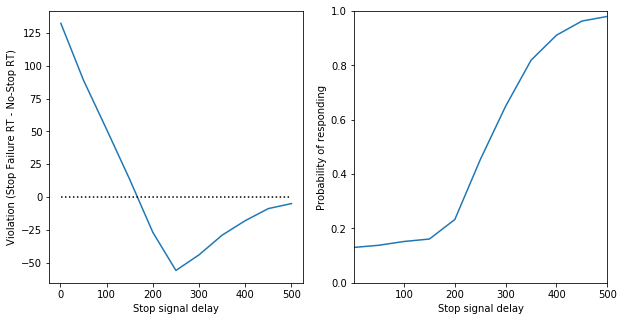

In [9]:
meanrtgo = data.groupby('SSD').mean()['RT'].values
presp = data.groupby('SSD').count()['RT'].values / params['nreps']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(params['ssds'][:-1],meanrtgo[:-1] - meanrtgo[-1])
plt.plot([params['ssds'][0],params['ssds'][10]],[0,0],'k:')
plt.xlabel('Stop signal delay')
plt.ylabel('Violation (Stop Failure RT - No-Stop RT)')
plt.subplot(1,2,2)
plt.plot(params['ssds'][:11],presp[:11])
plt.xlabel('Stop signal delay')
plt.ylabel('Probability of responding')
_ = plt.axis([params['ssds'][0],params['ssds'][10],0,1])

# "Variant of the Blocked Input Model in which the stop process decelerates the go process by a rate that varies across trials"

In [6]:
def blocked_input_variable_stop(params):
    data_dict = {
        'SSD': [],
        'rep': [],
        'go_process': [],
        'stop_process': [],
        'go_accum': [],
        'stop_accum': [],
        'RT': [],
        'mu_stop': []
    }
    for SSD in params['ssds']:
        stop_init_time = SSD + params['nondecisionstop']
        for rep in range(params['nreps']):
            go_process = []
            stop_process = []
            go_accum = 0
            stop_accum = 0
            RT = None
            time = 0
            mu_stop = at_least_0(params['mu_stop']+np.random.normal(loc=0, scale=params['noiseScale']*.7))
            while time < params['maxtime'] and RT is None:
                time = time + 1
                if time >= stop_init_time:
                    stop_accum = at_least_0(
                        mu_stop + np.random.normal(loc=0, scale=params['noiseScale']*.008)
                    )
                    stop_process.append(stop_accum)
                if time >= params['nondecisiongo']:
                    go_accum = at_least_0(
                        go_accum + params['mugo'] - \
                        params['inhibitionParam']*stop_accum + \
                        np.random.normal(loc=0, scale=params['noiseScale'])
                    )
                    go_process.append(go_accum)
                if go_accum > params['threshold']:
                    RT = time

            # Save data
            data_dict['SSD'].append(SSD)
            data_dict['rep'].append(rep)
            data_dict['RT'].append(RT)
            data_dict['go_process'].append(go_process)
            data_dict['stop_process'].append(stop_process)
            data_dict['go_accum'].append(go_accum)
            data_dict['stop_accum'].append(stop_accum)
            data_dict['mu_stop'].append(mu_stop)
    return pd.DataFrame(data_dict)

In [10]:
data = blocked_input_variable_stop(params)
data

,SSD,rep,go_process,stop_process,go_accum,stop_accum,RT,mu_stop
0,1,0,"[0, 0.9335858092014679, 0.6022839504972795, 2....","[0.037181545168132664, 0.05342555061528745, 0....",60.189423,0.019837,317.0,0.028612
1,1,1,"[0.5703150584455272, 1.2340604132339876, 0.175...","[1.7369494106115375, 1.7494613660574285, 1.745...",0.000000,1.728541,NaN,1.737097
2,1,2,"[0, 0, 0, 1.1421531386238128, 0.25649930891662...","[1.3439084659144558, 1.3562718722911653, 1.352...",0.000000,1.357573,NaN,1.352734
3,1,3,"[0.5917260192904097, 1.5678503816388747, 1.033...","[0.008885746826382929, 0, 0, 0.012142538089902...",60.343347,0.000000,338.0,0.000000
4,1,4,"[1.2185463836922719, 0, 0, 0, 0, 0, 0, 0.63443...","[1.0688378126616833, 1.075968436228995, 1.0785...",0.894226,1.076690,NaN,1.076046
...,...,...,...,...,...,...,...,...
11995,750,995,"[0.38599277257700504, 0.230679304705579, 0, 0....",[],60.788654,0.000000,336.0,1.877574
11996,750,996,"[0.44194977968831106, 0, 0, 0.6131705577767357...",[],60.025598,0.000000,389.0,0.275905
11997,750,997,"[0.6011740357200783, 0, 0.21174080760118805, 1...",[],60.036301,0.000000,461.0,0.356285
11998,750,998,"[0, 2.9729057060864332, 3.014595219266766, 2.3...",[],60.207103,0.000000,445.0,1.456455


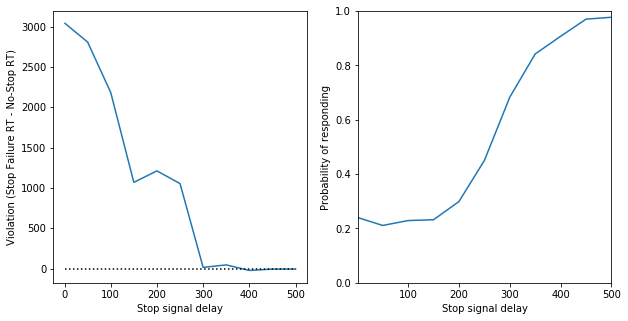

In [11]:
meanrtgo = data.groupby('SSD').mean()['RT'].values
presp = data.groupby('SSD').count()['RT'].values / params['nreps']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(params['ssds'][:-1],meanrtgo[:-1] - meanrtgo[-1])
plt.plot([params['ssds'][0],params['ssds'][10]],[0,0],'k:')
plt.xlabel('Stop signal delay')
plt.ylabel('Violation (Stop Failure RT - No-Stop RT)')
plt.subplot(1,2,2)
plt.plot(params['ssds'][:11],presp[:11])
plt.xlabel('Stop signal delay')
plt.ylabel('Probability of responding')
_ = plt.axis([params['ssds'][0],params['ssds'][10],0,1])

In [ ]:
params={'mugo':.2,
        'mu_stop':.8,
        'noiseScale': 1,
        'threshold':60,
        'nondecisiongo':50,
        'nondecisionstop':50,
        'inhibitionParam':1, 
        'ssds':[1,50,100,150, 200,250, 300, 350, 400, 450, 500, 750],
        'nreps':1000,
        'maxtime':100000,
        'pTriggerFail': .15
       }

In [24]:
class SimulateData():
    
    def __init__(self, model='independent_race', variable_mu_stop = False, trigger_failures=False, guesses=False, graded_mu_go = False):
        self.model = model
        self.variable_mu_stop = variable_mu_stop
        self.trigger_failures = trigger_failures
        self.guesses = guesses
        self.graded_mu_go = graded_mu_go
        trial_iterators = {
            'independent_race': self._independent_race_trial,
            'interactive_race': self._interactive_race_trial,
            'blocked_input': self._blocked_input_trial
        }
        self._trial_iter = _trial_iterators[model]
    
    def Simulate(self, params):
        data_dict = self._init_data_dict()
        guesses_per_ssd = self._get_guesses_per_ssd(params)
        for ssd_idx, SSD in enumerate(params['SSDs']):
            # guess trials
            n_guesses = guesses_per_ssd[ssd_idx]            
            guess_RTs = np.random.uniform(params['guess_min_RT'], params['guess_max_RT'], n_guesses)
            for trial_id, RT in enumerate(guess_RTs):
                data_dict = self._update_data_dict(
                    data_dict,
                    update_dict = {
                        'condition': 'stop',
                        'SSD': SSD,
                        'trial': trial_df,
                        'RT': RT,
                        'mu_go': np.nan,
                        'mu_stop': np.nan,
                        'go_accum': np.nan,
                        'stop_accum': np.nan,
                        'go_process': np.nan,
                        'stop_process': np.nan,
                    })
            
            # accumulator trials 
            stop_init_time = SSD + params['nondecisionstop']
            for trial_id in range(n_guesses, params['n_trials']):
                mu_stop = self._get_mu_stop(params)
                mu_stop = self._at_least_0(params['mu_stop']+np.random.normal(loc=0, scale=params['noiseScale']*.7))
                mu_go = self._get_mu_go(params, SSD)
                trial_info = {
                    'SSD': SSD,
                    'trial_id': trial_id,
                    'mu_go': mu_go,
                    'mu_stop': mu_stop,
                    'stop_init_time': stop_init_time,
                    'noise': params['noise'],
                    'nondecision_go': params['nondecision_go'],
                    'inhibition_interaction': params['inhibition_interaction'],
                    'threshold': params['threshold']
                }
                data_dict = self._trial_iter(data_dict, trial_info)

            
    def _blocked_input_trial(self, data_dict, trial_info):
        go_process = []
        stop_process = []
        go_accum = 0
        stop_accum = 0
        RT = None
        time = 0
        while time < params['maxtime'] and RT is None:
                time = time + 1
                if time >= stop_init_time:
                    stop_accum = at_least_0(
                        trial_info['mu_stop'] + np.random.normal(loc=0, scale=trial_info['noise']*.008)
                    )
                    stop_process.append(stop_accum)
                if time >= trial_ingo['nondecision_go']:
                    go_accum = at_least_0(
                        go_accum + trial_info['mu_go'] - \
                        trial['inhibition_interaction']*stop_accum + \
                        np.random.normal(loc=0, scale=trial_info['noise'])
                    )
                    go_process.append(go_accum)
                if go_accum > trial_info['threshold']:
                    RT = time
                    
        return self._update_data_dict(
            data_dict,
            update_dict = {'condition': 'stop',
                'SSD': trial_info['SSD'],
                'trial': trial_info['SSD'],
                'RT': RT,
                'mu_go': trial_info['mu_go'],
                'mu_stop': trial_info['mu_stop'],
                'go_accum': go_accum,
                'stop_accum': stop_accum,
                'go_process': go_process,
                'stop_process': stop_process,
            })
    
    def _init_data_dict(self):
        return {
            'condition': [],
            'SSD': [],
            'trial': [],
            'RT': [],
            'mu_go': [],
            'mu_stop': [],
            'go_accum': [],
            'stop_accum': [],
            'go_process': [],
            'stop_process': [],
            }
    
    def _update_data_dict(self, data_dict, update_dict):
        for key in update_dict:
            data_dict[key].append(update_dict[key])
        return data_dict
        
        
    def _def at_least_0(self, num):
        if num < 0:
            num = 0
        return num
        
    def _get_guesses_per_ssd(self, params):
        # TO DO: ADD ASSERTIONS TO CHECK FOR CORRECT USES, clean up!!!
        
        num_SSDs = len(params['SSDs'])
        if self._guesses:
            if type(params['p_guess'])==float:
                p_guesses_per_SSD = [params['p_guess']] * num_SSDs
            elif type(params['p_guess']) in [list, np.ndarray]:
                if len(params['p_guess']==1):
                    p_guesses_per_SSD = params['p_guess'] * num_SSDs
                else:
                    p_guesses_per_SSD = params['p_guess']
        else:
            p_guesses_per_SSD = [0] * num_SSDs
            
        assert(len(p_guesses_per_SSD) == num_SSDs)
        
        # convert to n trials to guess per SSD
        guesses_per_SSD = [int(np.round(p * params['n_trials'])) for p in p_guesses_per_SSD]
        return guesses_per_SSD

In [28]:
for i in range(50, 100):
    print(i)

50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [21]:
type(np.array([1]))

numpy.ndarray

In [26]:
for i in np.random.uniform(-1,0,0):
    print(i)